<a href="https://colab.research.google.com/github/amanjain252002/Implementation-of-Word2vec-and-GloVe/blob/main/skip_gram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tqdm import tqdm

import nltk
nltk.download('punkt')

import tensorflow as tf
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2.4.1


## Data Preprocessing

In [2]:
with open("/content/Database.txt", errors = 'ignore') as f:
  Data = f.read()

In [3]:
# Converts data to lowercase
Data = Data.lower()
# Removes numbers from the data
Data = re.sub(r'[0-9]+', ' ', Data)
# Removes special characters from the data
Data = re.sub(r'[^A-Za-z0-9 ]+', ' ', Data)

Tokenization is the process by which a large quantity of text is divided into smaller parts called tokens. These tokens are very useful for finding patterns and are considered as a base step for stemming and lemmatization. Tokenization also helps to substitute sensitive data elements with non-sensitive data elements.

In [4]:
words = nltk.word_tokenize(Data)

In [5]:
# Generates word_to_index and index_to_word dictionary
word_to_index = {}
index_to_word = {}
count = 0
for word in words:
  if(word not in word_to_index.keys()):
    word_to_index[word] = count
    count = count + 1
for word in word_to_index.keys():
  index_to_word[word_to_index[word]] = word

In [6]:
def get_window(words, window_size):
  Dataset = []
  for i in range(len(words)):
    for j in range(i - window_size, i + window_size + 1, 1):
      if(j < 0 or j > (len(words) - 1) or j == i):
        continue
      Dataset.append((words[i], words[j]))
  return Dataset

In [7]:
# Genrates one hot vector of word
def word_to_one_hot_vector(word, word_to_index):
  one_hot_vector = np.zeros(shape = (len(word_to_index), 1))
  one_hot_vector[word_to_index[word]][0] = 1
  return one_hot_vector

In [8]:
def get_training_example(words, window_size, word_to_index):
  X_train, y_train = [], []
  Dataset = get_window(words, window_size)
  batch_size = 100
  for i in range(1, 100000, batch_size):
    for centre_word, context_word in Dataset[i: i+batch_size-1]:
      X_train.append(word_to_one_hot_vector(centre_word, word_to_index))
      y_train.append(word_to_one_hot_vector(context_word, word_to_index))
  
  return X_train, y_train

In [9]:
X_train, y_train = get_training_example(words, 3, word_to_index)

In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [11]:
print(X_train.shape)
print(y_train.shape)

(99000, 1028, 1)
(99000, 1028, 1)


In [12]:
X_train = np.array(X_train).reshape(1028, 99000)
print(X_train.shape)
y_train = np.array(y_train).reshape(1028, 99000)
print(y_train.shape)

(1028, 99000)
(1028, 99000)


## Modeling

In [13]:
# Random normal weights intialization
def Weight_Intialization(V, n_Hidden):
  W1 = np.random.randn(n_Hidden, V)
  b1 = np.random.randn(n_Hidden, 1)
  W2 = np.random.randn(V, n_Hidden)
  b2 = np.random.randn(V, 1)
  return W1, b1, W2, b2

In [14]:
# Activation function
def relu(z):
  return np.maximum(0, z)

In [15]:
# Activation function
def softmax(z):
  ex = np.exp(z)
  return ex/np.sum(ex, axis = 0)

In [16]:
# Forward Propagation
def forward_pass(x, W1, b1, W2, b2):
  Z1 = np.dot(W1, x) + b1
  Z1 = relu(Z1)
  Z2 = np.dot(W2, Z1) + b2
  ypred = softmax(Z2)
  return Z1, Z2, ypred

In [17]:
def error_calculation(y, ypred, m):
  error = -(np.sum(np.multiply(y, np.log(ypred))))/m
  return error

In [18]:
# Back Propagation
def back_prop(W1, b1, W2, b2, Z1, Z2, y, ypred, x):
  dW1 = np.dot(relu(np.dot(W2.T, ypred - y)), x.T)
  db1 = relu(np.dot(W2.T, ypred - y))
  dW2 = np.dot(ypred - y, Z1.T)
  db2 = ypred - y
  return dW1, db1, dW2, db2

In [19]:
# Model
def model(x, y, epoches = 10, learning_rate = 0.01):
  V = x.shape[0]
  m = x.shape[1]
  n_Hidden = 300
  W1, b1, W2, b2 = Weight_Intialization(V, n_Hidden)
  error = []
  for i in tqdm(range(epoches)):
    Z1, Z2, ypred = forward_pass(x, W1, b1, W2, b2)
    error.append(error_calculation(y, ypred, m))
    dW1, db1, dW2, db2 = back_prop(W1, b1, W2, b2, Z1, Z2, y, ypred, x)
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
  return ypred, error, W1, W2

In [20]:
ypred, error, W1, W2 = model(X_train, y_train, 10, 0.00001)

100%|██████████| 10/10 [03:14<00:00, 19.43s/it]


In [21]:
W = np.add(W1, W2.T)/2

In [22]:
# Generates word to word embedding dictionary
word_to_vector = {}
for word in word_to_index.keys():
  word_to_vector[word] = W[:, word_to_index[word]]

## Principal component analysis 

Word Embeddings has 300 dimensions, so to visualise, we used PCA to reduce it into 2 dimensions. 

In [23]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(W.T)

In [24]:
word_to_reduce_vector = {}
for word in word_to_index.keys():
  word_to_reduce_vector[word] = principalComponents[word_to_index[word], :]

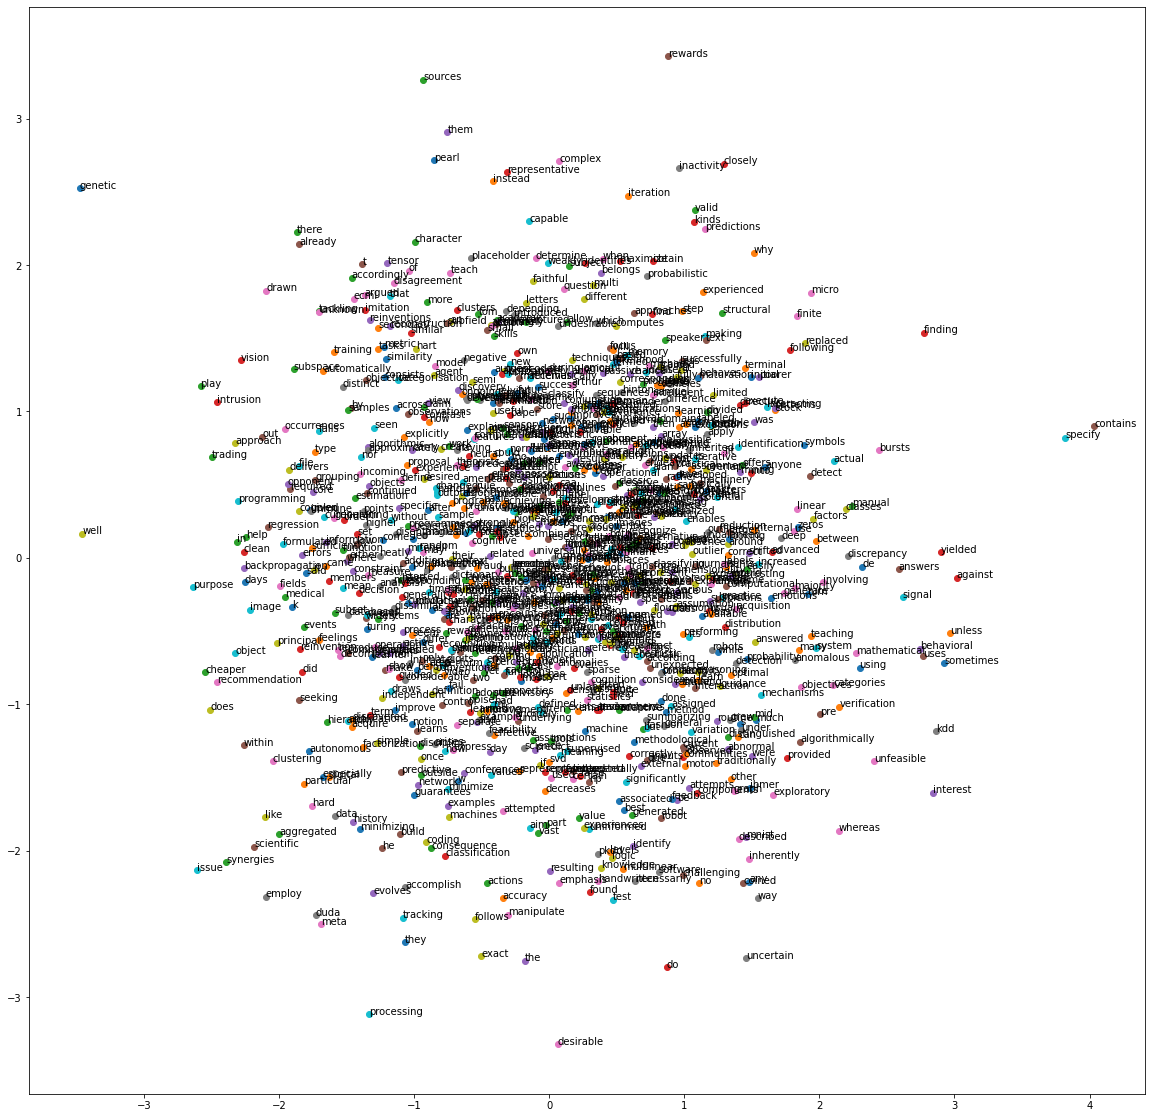

In [25]:
plt.figure(figsize = (20, 20))
for word, vector in word_to_reduce_vector.items():
  plt.scatter(vector[0], vector[1])
  plt.annotate(word, (vector[0], vector[1]))
plt.show() 